Elise Metayer

Fanny Shehabi

# $\color{brown}{\text{Projet d'IIA : Fish Market}}$


L'objectif de ce projet est de définir un modèle prédictif pour le poids du poisson.

In [1]:
# importation des librairies nécéssaires
# pour calcul numerique, chargement des données, visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tpiia_utils

# fonctions de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

Dans un premier temps, importons les données des ventes de la poissonerie. L'espèce ne semble pas être un attribut très pertinent pour notre analyse, face aux autres attributs que l'on possède.

In [2]:
fish_df = pd.read_csv('./Data/fish.csv', sep=',')
fish_df = fish_df.drop("Species", axis=1)
# Affichage des 5 premieres lignes du dataframe
fish_df.head()

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
print("Résumé des données")
fish_df.info()

Résumé des données
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Weight   159 non-null    float64
 1   Length1  159 non-null    float64
 2   Length2  159 non-null    float64
 3   Length3  159 non-null    float64
 4   Height   159 non-null    float64
 5   Width    159 non-null    float64
dtypes: float64(6)
memory usage: 7.6 KB


Dans le jeu de données, il y a 159 exemples. La variable cible est le poids ('Weight'). Il y a 6 attributs.

<Axes: >

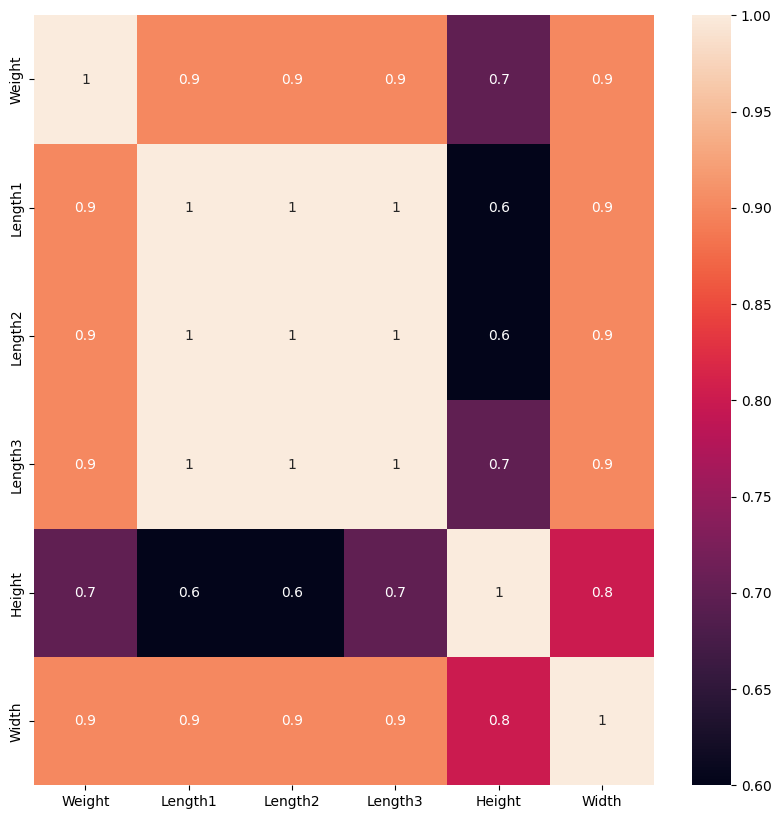

In [4]:
#etude de la correlation (arrondi à une décimale)
matrice_corr = fish_df.corr().round(1)
fig, ax = plt.subplots(figsize=(10, 10)) #specify size of heatmap
sns.heatmap(data=matrice_corr, annot=True)

La matrice de corrélation met en évidence un groupe d'attributs fortement corrélés. On en déduit que l'utilisation de la régularisation de Lasso pourra être pertinente.

On normalise les attributs de manière à ce qu'ils varient dans le même intervalle afin que la régularisation ait le même effet sur chacun d'eux.

## <font color="#9E7FC1">Normalisation des données</font>

In [5]:
scaler = MinMaxScaler()

# on utilise le scaler.fit_transform method
# l'expression est un peu plus compliquée pour maintenir le format DataFrame, si non le résultat est un numpy array
fish_df_norm=pd.DataFrame(scaler.fit_transform(fish_df.values),columns=fish_df.columns, index=fish_df.index )

fish_df_norm.head()

,Weight,Length1,Length2,Length3,Height,Width
0,0.146667,0.304854,0.309091,0.358108,0.568334,0.418978
1,0.175758,0.320388,0.325455,0.378378,0.624055,0.459235
2,0.206061,0.318447,0.329091,0.376689,0.618123,0.514279
3,0.220000,0.365049,0.374545,0.417230,0.638566,0.480365
4,0.260606,0.368932,0.374545,0.425676,0.621966,0.576004


In [6]:
# Define the X (input) and y (target) features
X = fish_df_norm.drop("Weight", axis=1)
y = fish_df_norm["Weight"]

# Split into train (2/3) and test (1/3) sets
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=5)

## <font color="#9E7FC1">Régularisation Linéaire : référence</font>

Dans un premier temps, nous allons entraîner un modèle avec la régression linéaire afin de confronter les différents modèles.

In [7]:
# apprentissage du modèle
lreg_model=LinearRegression() 
lreg_model.fit(X_train, y_train)
print("Estimated coefficients :",lreg_model.coef_)
print("Independent term in the linear model :",lreg_model.intercept_)

Estimated coefficients : [ 2.46979228 -1.45306172 -0.39308354  0.24088918  0.17588967]
Independent term in the linear model : -0.16223391004754023


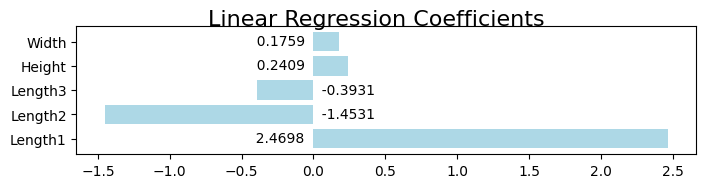

In [8]:
# Visualisation du modèle
tpiia_utils.linearRegressionSummary(lreg_model, X.columns)

In [9]:
y_pred=lreg_model.predict(X_test)
y_pred_train=lreg_model.predict(X_train)

baseline_error_test = mean_squared_error(y_pred,y_test)
baseline_error_train = mean_squared_error(y_pred_train,y_train)
print("Linear regression: MSE on test set: %.4f" % baseline_error_test)
print("Linear regression: MSE on train set: %.4f" % baseline_error_train)

print("Coefficient of determination on test set: %.2f" % r2_score(y_test,y_pred))
print("Coefficient of determination on train set: %.2f" % r2_score(y_train,y_pred_train))

Linear regression: MSE on test set: 0.0051
Linear regression: MSE on train set: 0.0056
Coefficient of determination on test set: 0.88
Coefficient of determination on train set: 0.88


Les résultats de ce premier modèle semblent tout à fait satisfaisant. En effet, les MSE sont très proches de 0 et les coefficients de détermination sont relativement proches de 1.

Nous allons entraîner un modèle avec la régularisation de Lasso afin de tester l'hypothèse que l'on a eu après visualisation de la matrice de corrélation.

## <font color="#9E7FC1">Régularisation de Lasso</font>

In [10]:
# Selection de modèle Lasso, avec validation croisée# Si on ne precise pas les alphas, il va automatiquement identifier l'intervalle. 
# Aussi si on ne precise pas autrement, n_alphas = 100 

lasso_regCV_norm = LassoCV(cv=4)
lasso_regCV_norm.fit(X_train, y_train)

# Afficher la valeur retenue de alpha 
a = lasso_regCV_norm.alpha_
print('alpha: %f' % a)

alpha: 0.000049


In [11]:
lreg_lasso_norm = Lasso(alpha=a)
lreg_lasso_norm.fit(X_train,y_train)

Lasso(alpha=4.909517172159613e-05)

[4.90951717e-02 4.57863215e-02 4.27004766e-02 3.98226074e-02
 3.71386970e-02 3.46356731e-02 3.23013446e-02 3.01243421e-02
 2.80940623e-02 2.62006165e-02 2.44347827e-02 2.27879601e-02
 2.12521278e-02 1.98198056e-02 1.84840170e-02 1.72382561e-02
 1.60764553e-02 1.49929561e-02 1.39824810e-02 1.30401086e-02
 1.21612489e-02 1.13416214e-02 1.05772341e-02 9.86436393e-03
 9.19953882e-03 8.57952069e-03 8.00128971e-03 7.46202956e-03
 6.95911374e-03 6.49009277e-03 6.05268224e-03 5.64475171e-03
 5.26431434e-03 4.90951717e-03 4.57863215e-03 4.27004766e-03
 3.98226074e-03 3.71386970e-03 3.46356731e-03 3.23013446e-03
 3.01243421e-03 2.80940623e-03 2.62006165e-03 2.44347827e-03
 2.27879601e-03 2.12521278e-03 1.98198056e-03 1.84840170e-03
 1.72382561e-03 1.60764553e-03 1.49929561e-03 1.39824810e-03
 1.30401086e-03 1.21612489e-03 1.13416214e-03 1.05772341e-03
 9.86436393e-04 9.19953882e-04 8.57952069e-04 8.00128971e-04
 7.46202956e-04 6.95911374e-04 6.49009277e-04 6.05268224e-04
 5.64475171e-04 5.264314

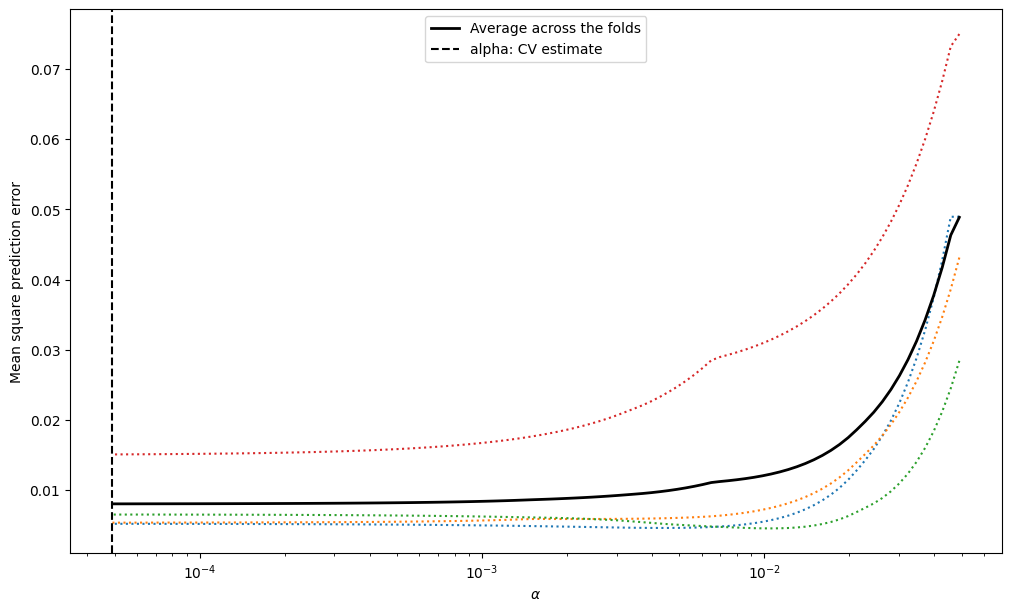

In [12]:
# Visualisation des résultats
tpiia_utils.plotLassoPredictionError(lasso_regCV_norm)

In [13]:
y_pred_lasso=lreg_lasso_norm.predict(X_test)
y_pred_train_lasso=lreg_lasso_norm.predict(X_train)

lasso_error_test = mean_squared_error(y_pred_lasso,y_test)
lasso_error_train = mean_squared_error(y_pred_train_lasso,y_train)
print("Lasso regression: MSE on test set: %.4f" % lasso_error_test)
print("Lasso regression: MSE on train set: %.4f" % lasso_error_train)
print()
print("Coefficient of determination on test set: %.2f" % r2_score(y_test,y_pred))
print("Coefficient of determination on train set: %.2f" % r2_score(y_train,y_pred_train))

Lasso regression: MSE on test set: 0.0052
Lasso regression: MSE on train set: 0.0057

Coefficient of determination on test set: 0.88
Coefficient of determination on train set: 0.88


Les résultats obtenus avec la régression linéaire régularisée ne donnent pas des résultats significativement différents de ceux sans régularisation.

On peut expliquer cela par le fait que tous les attributs sont plus ou moins corrélés entre eux (cf matrice de corrélation).

## <font color="#9E7FC1">Modèle linéaire avec expansion polynomiale</font>

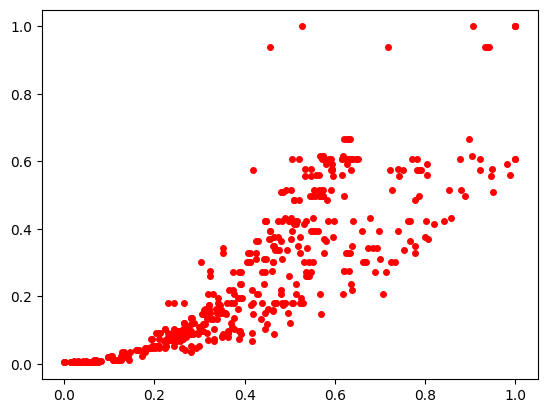

In [14]:
#Visualisation des données
plt.plot(X_train, y_train, 'ro', markersize=4)

La répartition des points peut facilement faire penser à l'allure de la courbe d'un polynôme de degré deux. 

Nous allons donc tester cette hypothèse. Commençons par chercher le meilleur hyperparamètre pour notre modèle. Pour cela, on utilise la fonction GridSearchCV.

      Length1   Length2   Length3    Height     Width
134  0.631068  0.620000  0.619932  0.322232  0.461618
83   0.223301  0.229091  0.231419  0.243148  0.318547
10   0.405825  0.410909  0.462838  0.727534  0.571803
140  0.792233  0.787273  0.782095  0.417782  0.722203
13   0.427184  0.429091  0.481419  0.707225  0.567377
15   0.425243  0.429091  0.479730  0.795747  0.638870
65   0.211650  0.210909  0.229730  0.415843  0.316475
43   0.250485  0.247273  0.268581  0.236589  0.381540
60   0.578641  0.574545  0.586149  0.616742  0.772074
33   0.580583  0.592727  0.626689  0.981333  0.803408
{'polynomialfeatures__degree': 2}
-0.0023688441801163447


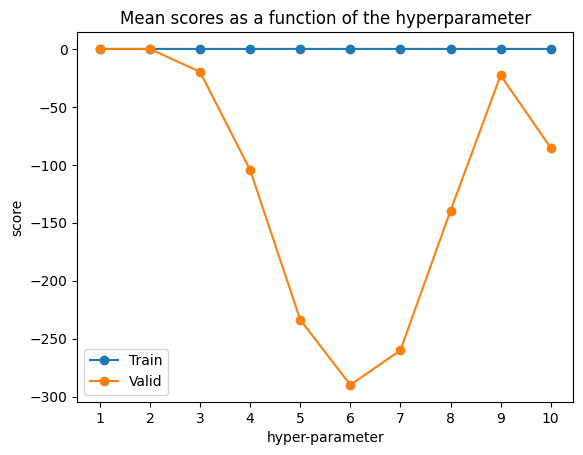

In [15]:
# Define the X (input) and y (target) features
X = fish_df_norm.drop("Weight", axis=1)
y = fish_df_norm["Weight"]

# Split into train (2/3) and test (1/3) sets
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=4)

#hyperparametres à explorer : nom et valeurs
hyperparams = [{'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

# création d'un pipeline (stocké dans la variable 'estimator') qui combine une expansion polynomiale et la regression linéaire
estimator = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())

# GridSearchCV va evaluer l'accuracy des modèles, pour les différentes valeurs des hyperparametres,
# avec une validation croisé (ici, 3 plis)
clf = GridSearchCV(estimator, hyperparams, cv = 2, scoring='neg_mean_squared_error', return_train_score=True)
clf.fit(X_train, y_train)
print(X_train[:10])

# Affichage du détails des informations
cv_results_df=pd.DataFrame.from_dict(clf.cv_results_)

# visualisation des résultats
tpiia_utils.plotMeanScores(hyperparams[0]['polynomialfeatures__degree'],cv_results_df )

#afficher le meilleur param et meilleur accuracy
print(clf.best_params_)
print(clf.best_score_)

La sélection de modèle nous montre que le meilleur hyperparamètre pour notre modèle est le degré 2. Nous allons donc entraîner notre modèle de régression linéaire avec une expansion polynomiale de degré 2.

In [16]:
X_train_p2 = PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_train)
X_test_p2 =  PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_test)

# apprentissage du modèle
lreg_model_poly=LinearRegression()
lreg_model_poly.fit(X_train_p2, y_train)
print("Estimated coefficients :",lreg_model_poly.coef_)
print("Independent term in the linear model :",lreg_model_poly.intercept_)

Estimated coefficients : [ 1.25856650e+00 -4.25752295e-01 -1.53116289e+00  1.92678449e-01
  1.94708988e-01 -2.44294270e+01 -9.79573716e+00  4.19362682e+01
  2.31472012e+00  7.96841896e+00 -5.72260022e+00  2.61691155e+01
 -6.13069858e+00  1.56199288e+00 -2.61803353e+01  4.90389207e+00
 -1.12492152e+01 -1.39878739e+00  1.83368906e+00  2.48157006e-03]
Independent term in the linear model : 0.02733707115005332


In [17]:
y_pred=lreg_model_poly.predict(X_test_p2)
y_pred_train=lreg_model_poly.predict(X_train_p2)

baseline_error_test = mean_squared_error(y_pred,y_test)
baseline_error_train = mean_squared_error(y_pred_train,y_train)
print("Polynomial regression: MSE on test set: %.4f" % baseline_error_test)
print("Polynomial regression: MSE on train set: %.4f" % baseline_error_train)

print("Coefficient of determination on test set: %.2f" % r2_score(y_test,y_pred))
print("Coefficient of determination on train set: %.2f" % r2_score(y_train,y_pred_train))

Polynomial regression: MSE on test set: 0.0017
Polynomial regression: MSE on train set: 0.0007
Coefficient of determination on test set: 0.97
Coefficient of determination on train set: 0.98


Les résultats de ce modèle sont très satisfaisant.

Résumé des performances des différents modèles :

| Modèle | MSE Réelle | MSE Empirique | R2 Réel | R2 Empirique |
|--------|------------|---------------|---------|--------------|
| Simple |   0.0051   |    0.0056     |   0.88  |      0.88    |
| Régularisation de Lasso |   0.0052   |    0.0057     |   0.88  |      0.88    | 
| Expansion Polynomiale de degré 2 |   0.0009   |    0.0008     |   0.98  |      0.98    | 


Le meilleur modèle correspond au modèle de régression linéaire avec expansion polynomiale de degré 2.